In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader as GeoDataLoader
from torch_geometric.nn import GCNConv

from src.get_data import collect_data_from_matches

from src.model_building import build_graph_from_frame, TemporalRunnerDataset, TemporalRunnerGNN, train_model, collate_fn, predict_optimal_run

from src.visualization_tools import plot_soccer_pitch
from src.visualization_tools import animate_run
from src.visualization_tools import plot_spatial_graph
from src.visualization_tools import plot_optimal_run

# Load Data

In [3]:
matches = [1886347]
possessions, run_features, tracking_data, player_to_team, merged = collect_data_from_matches(matches)


100%|██████████| 1/1 [00:38<00:00, 38.42s/it]


In [2]:
match_info = pd.read_csv("data/matches_info.csv")
possessions = pd.read_csv("data/possessions.csv")
run_features = pd.read_csv("data/run_features.csv")
tracking_data = pd.read_csv("data/tracking_data.csv")
player_to_team = pd.read_csv("data/player_team.csv").set_index("id")

merged = pd.merge(possessions,run_features,on=["match_id","possession_index"],how="outer",suffixes=("_possession","_run"))

merged["possession_lead_to_shot"] = (merged["possession_lead_to_shot"] | merged["lead_to_shot"])# Need to update wheter runs and possessions lead to shots on values that conflict
merged["possession_lead_to_goal"] = (merged["possession_lead_to_goal"] | merged["lead_to_goal"])


In [3]:
merged.event_subtype.unique()

array(['pulling_wide', 'coming_short', 'behind', nan, 'support',
       'overlap', 'cross_receiver', 'dropping_off',
       'run_ahead_of_the_ball', 'pulling_half_space', 'underlap'],
      dtype=object)

In [4]:
run_types_to_predict = ['cross_receiver','behind',"run_ahead_of_the_ball","overlap","underlap","support"]
runs_to_predict = merged[merged.event_subtype.isin(run_types_to_predict)]
run_type_vocab = {rt: i for i, rt in enumerate(sorted(run_types_to_predict))}

In [5]:
tracking_frame_groups = {
    (mid, rid): df
    for (mid, rid), df in tracking_data.groupby(
        ["match_id", "run_id"]
    )
}

# Validating that we can build graphs for each run

In [6]:
def validate_run(run_row):
    runner_id = run_row["player_id"]
    match_id = run_row["match_id"]
    run_id = run_row["event_id"]

    frame_start = int(run_row["frame_start_run"])
    frame_end = int(run_row["frame_end_run"])
    
    if frame_end - frame_start <= 10:
        return False

    tracking = tracking_frame_groups[(match_id, run_id)]

    lower_frame = frame_start-10
    
    if lower_frame < tracking["frame_id"].min():
        return False
    
    expected_frames = set(range(lower_frame, frame_end + 1))
    actual_frames = set(tracking["frame_id"].unique().tolist())

    if not expected_frames.issubset(actual_frames):
        return False
    
    runner_per_frame = (
        tracking
        .groupby("frame_id")["player"]
        .apply(lambda players: runner_id in players.values)
    )
    return runner_per_frame.all()
runs_to_predict = runs_to_predict[runs_to_predict.apply(validate_run,axis=1)]

<Axes: >

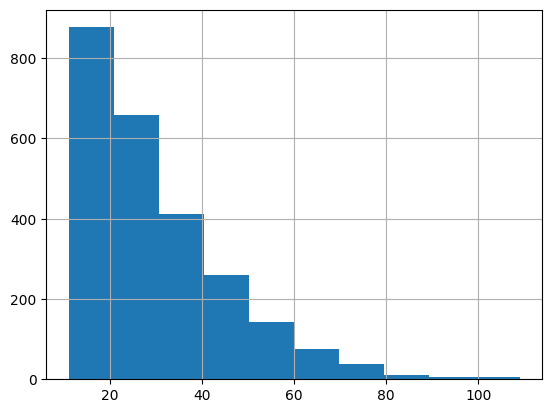

In [8]:
(runs_to_predict["frame_end_run"] - runs_to_predict["frame_start_run"]).hist()

# Build Graph

In [9]:
RUN_NUM = 0
RUN_FRAME = 2
run = runs_to_predict.iloc[RUN_NUM]
match_id = run["match_id"]
run_id = run["id"]
player = run["player_id"]

run_tracking = tracking_data[(tracking_data.run_id == run_id) & (tracking_data.match_id == match_id)]
run_tracking["timestamp"] = pd.to_timedelta(run_tracking["timestamp"]).dt.total_seconds()
frame_num = run_tracking["frame_id"].sort_values().iloc[0] + RUN_FRAME
frame_df = run_tracking[run_tracking["frame_id"]==frame_num]


graph = build_graph_from_frame(frame_df=frame_df,runner_player_id=player,player_to_team=player_to_team)
graph

Data(x=[23, 10], edge_index=[2, 506], edge_attr=[506, 4], runner_idx=21, team_ids=[23], is_ball=[23])

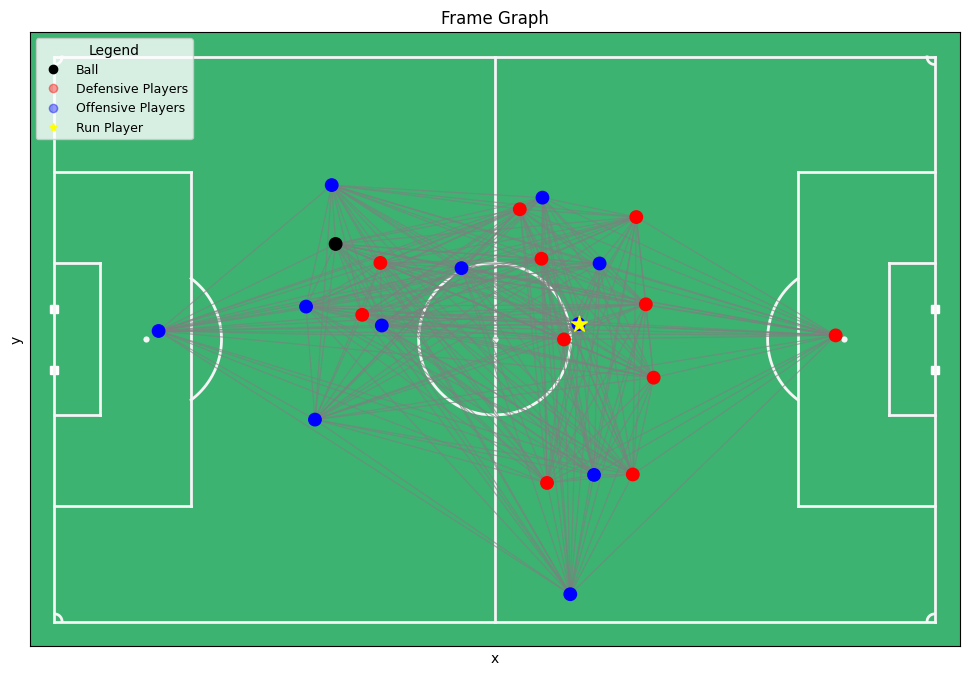

In [10]:
%matplotlib inline
plot_spatial_graph(graph)

In [11]:
run_type_vocab

{'behind': 0,
 'cross_receiver': 1,
 'overlap': 2,
 'run_ahead_of_the_ball': 3,
 'support': 4,
 'underlap': 5}

# Temporal Dataset class

In [104]:
class TemporalRunnerDataset(Dataset):
    def __init__(self, tracking_df, run_features, player_to_team):
        self.df = tracking_df
        self.run_features = run_features
        self.player_to_team = player_to_team

    def __len__(self):
        return len(self.run_features)

    def __getitem__(self, idx):
        run = self.run_features.iloc[idx]

        match_id = run["match_id"]
        run_id = run["event_id"]
        runner_id = run["player_id"]
        run_type = run["event_subtype"]
        run_type_id = run_type_vocab[run_type]

        frame_start = int(run["frame_start_run"])
        frame_end   = int(run["frame_end_run"])

        run_tracking = self.df[(match_id, run_id)]
        run_tracking = run_tracking.sort_values("frame_id")

        graphs = []
        runner_positions = []

        # --- anchor position ---
        start_row = run_tracking[
            (run_tracking["frame_id"] == frame_start) &
            (run_tracking["player"] == runner_id)
        ].iloc[0]

        x0, y0 = start_row["x"], start_row["y"]

        for t in range(frame_start - 10, frame_end + 1):
            frame_df = run_tracking[run_tracking["frame_id"] == t]

            g = build_graph_from_frame(
                frame_df=frame_df,
                runner_player_id=runner_id,
                player_to_team=self.player_to_team
            )
            graphs.append(g)
            if t>=frame_start:
                runner_row = frame_df[frame_df["player"] == runner_id].iloc[0]
                runner_positions.append([
                    runner_row["x"] - x0,
                    runner_row["y"] - y0
                ])

        graphs_batch = Batch.from_data_list(graphs)

        target_path = torch.tensor(runner_positions, dtype=torch.float)  # [L,2]
        
        lead_to_shot_val = self.run_features.loc[self.run_features['id'] == run_id, 'possession_lead_to_shot'].values
        if len(lead_to_shot_val) == 0:
            shot_label = torch.tensor(0.0) 
        else:
            shot_label = torch.tensor(float(lead_to_shot_val[0]))
        
        lead_to_goal_val = self.run_features.loc[self.run_features['id'] == run_id, 'possession_lead_to_goal'].values
        if len(lead_to_goal_val) == 0:
            goal_label = torch.tensor(0.0) 
        else:
            goal_label = torch.tensor(float(lead_to_goal_val[0]))
        

        return graphs, target_path, shot_label, goal_label, run_type_id

def collate_fn(batch, max_len=100):
    graphs_list, targets_list, shot_labels_list, goal_labels_list, run_type_id_list = zip(*batch)

    batch_graphs = Batch.from_data_list([g for graphs in graphs_list for g in graphs])

    lengths = [len(target) for target in targets_list]

    padded_targets = torch.zeros(len(targets_list), max_len, 2)  # fixed max_len padding

    for i, target in enumerate(targets_list):
        length = min(len(target), max_len)
        padded_targets[i, :length] = target[:length]

    # Adjust lengths to max_len if longer sequences exist
    lengths = [min(l, max_len) for l in lengths]
    shot_labels = torch.tensor(shot_labels_list, dtype=torch.float)
    goal_labels = torch.tensor(goal_labels_list, dtype=torch.float)
    run_type_labels = torch.tensor(run_type_id_list, dtype=torch.long)


    return batch_graphs, padded_targets, lengths, shot_labels, goal_labels, run_type_labels

In [105]:
dataset = TemporalRunnerDataset(
    tracking_df=tracking_frame_groups,
    run_features=runs_to_predict,
    player_to_team=player_to_team,
)
dataset

In [106]:
graphs,target, shot, goal, runtype =  dataset[0]
len(graphs), len(target)

(28, 18)

# Temporal GNN

In [107]:
from torch_geometric.nn import TransformerConv
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class TemporalRunnerGNN_V4(nn.Module):
    def __init__(self, node_feat_dim, edge_dim, gnn_hidden_dim, K):
        super().__init__()

        self.gnn1 = TransformerConv(
            in_channels=node_feat_dim,
            out_channels=gnn_hidden_dim,
            heads=4,
            concat=False,
            edge_dim=edge_dim,
            dropout = .1
        )

        self.gnn2 = TransformerConv(
            in_channels=gnn_hidden_dim,
            out_channels=gnn_hidden_dim,
            heads=4,
            concat=False,
            edge_dim=edge_dim,
            dropout=.1
        )
        self.run_type_dim = 16

        self.temporal_proj = nn.Linear(
            gnn_hidden_dim + self.run_type_dim,
            gnn_hidden_dim
        )


        self.temporal_pe = nn.Parameter(
            torch.randn(1, 100, gnn_hidden_dim) * 0.01 
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=gnn_hidden_dim,
            nhead=4,
            dim_feedforward=4 * gnn_hidden_dim,
            dropout=0.1,
            batch_first=True
        )

        self.temporal_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=2
        )
        num_run_types = K
        run_type_dim = 16

        self.run_type_head = nn.Linear(gnn_hidden_dim, num_run_types)
        self.run_type_emb = nn.Embedding(num_run_types, run_type_dim)
        
        self.pos_head = nn.Linear(gnn_hidden_dim, 2)
        self.shot_head = nn.Linear(gnn_hidden_dim, num_run_types) 
        
    def forward(self, graphs_batch, lengths):
        device = next(self.parameters()).device
        graphs_batch = graphs_batch.to(device)

        x, edge_index, edge_attr = (
            graphs_batch.x,
            graphs_batch.edge_index,
            graphs_batch.edge_attr,
        )

        edge_attr = edge_attr / edge_attr.std(dim=0, keepdim=True).clamp(min=1e-6)

        # --------------------
        # GNN encoder
        # --------------------
        x = F.relu(self.gnn1(x, edge_index, edge_attr))
        x = F.relu(self.gnn2(x, edge_index, edge_attr))

        batch_vec = graphs_batch.batch
        runner_idx = graphs_batch.runner_idx
        total_graphs = runner_idx.size(0)

        B = len(lengths)
        max_len = max(lengths)

        # --------------------
        # Extract runner embedding per graph
        # --------------------
        runner_embeds_per_graph = []
        for t in range(total_graphs):
            node_mask = batch_vec == t
            node_indices = node_mask.nonzero(as_tuple=False).view(-1)
            global_runner_idx = node_indices[runner_idx[t]]
            runner_embeds_per_graph.append(x[global_runner_idx])

        # --------------------
        # Pack into (B, T, H)
        # --------------------
        runner_embeds_per_run = []
        start = 0
        for length in lengths:
            run_embeds = runner_embeds_per_graph[start : start + length]
            start += length

            if length < max_len:
                pad = [torch.zeros_like(run_embeds[0])] * (max_len - length)
                run_embeds.extend(pad)

            runner_embeds_per_run.append(torch.stack(run_embeds))

        runner_embeds_batch = torch.stack(runner_embeds_per_run)  # (B, T, H)

        B, T, H = runner_embeds_batch.shape
        T_intent = 10

        # ============================================================
        # 1) INTENT ENCODER (FIRST 10 FRAMES ONLY)
        # ============================================================
        x_intent = runner_embeds_batch[:, :T_intent]
        x_intent = x_intent + self.temporal_pe[:, :T_intent]

        intent_mask = torch.triu(
            torch.ones(T_intent, T_intent, device=device), diagonal=1
        ).bool()

        intent_out = self.temporal_encoder(
            x_intent,
            mask=intent_mask,
        )

        intent_state = intent_out[:, -1]  # (B, H)

        # Run type prediction (early intent)
        run_type_logits = self.run_type_head(intent_state)
        run_type_probs = F.softmax(run_type_logits, dim=-1)

        # ============================================================
        # 2) FULL-RUN ENCODER (ALL FRAMES)
        # ============================================================
        x_full = runner_embeds_batch + self.temporal_pe[:, :T]

        full_mask = torch.triu(
            torch.ones(T, T, device=device), diagonal=1
        ).bool()

        padding_mask = (
            torch.arange(T, device=device)[None, :]
            >= torch.tensor(lengths, device=device)[:, None]
        )

        full_out = self.temporal_encoder(
            x_full,
            mask=full_mask,
            src_key_padding_mask=padding_mask,
        )

        full_state = full_out[:, -1]  # (B, H)

        # Shot probability per run type (counterfactual)
        shot_logits_per_type = self.shot_head(full_state)  # (B, K)
        shot_probs_per_type = F.softmax(shot_logits_per_type, dim=-1)

        # ============================================================
        # 3) PATH DECODER (ALL FRAMES, PER RUN TYPE)
        # ============================================================
        run_paths = []

        for k in range(self.run_type_emb.num_embeddings):
            run_type_embed = self.run_type_emb.weight[k]
            run_type_embed = (
                run_type_embed.unsqueeze(0)
                .unsqueeze(0)
                .expand(B, T, -1)
            )

            x_path = torch.cat([runner_embeds_batch, run_type_embed], dim=-1)
            x_path = self.temporal_proj(x_path)
            x_path = x_path + self.temporal_pe[:, :T]

            path_out = self.temporal_encoder(
                x_path,
                mask=full_mask,
                src_key_padding_mask=padding_mask,
            )

            pred_path = self.pos_head(path_out)  # (B, T, 2)
            run_paths.append(pred_path)

        run_paths = torch.stack(run_paths, dim=1)  # (B, K, T, 2)

        # ============================================================
        # OUTPUT
        # ============================================================
        return {
            "run_type_logits": run_type_logits,
            "run_type_probs": run_type_probs,
            "shot_logits_per_type": shot_logits_per_type,
            "shot_probs_per_type": shot_probs_per_type,
            "run_paths_per_type": run_paths,
        }

In [108]:
node_feat_dim = 10
edge_dim = 4
gnn_hidden_dim = 64   
K = len(run_type_vocab)
model = TemporalRunnerGNN_V4(node_feat_dim,edge_dim,gnn_hidden_dim,K)
#model = TemporalRunnerGNN(node_feat_dim, gnn_hidden_dim, rnn_hidden_dim)

# Training Loop

In [109]:
def trajectory_diversity_loss(run_paths, lengths, eps=1e-6):
    """
    run_paths: (B, K, T, 2)
    lengths: list[int]
    """
    B, K, T, _ = run_paths.shape
    loss = 0.0
    count = 0

    for i in range(B):
        T_i = lengths[i]
        paths = run_paths[i, :, :T_i]  # (K, T_i, 2)

        # flatten trajectories
        paths_flat = paths.reshape(K, -1)  # (K, 2*T_i)

        # normalize (important!)
        paths_flat = F.normalize(paths_flat, dim=1)

        # cosine similarity matrix
        sim = paths_flat @ paths_flat.T  # (K, K)

        # remove diagonal
        loss += (sim.sum() - torch.trace(sim)) / (K * (K - 1))
        count += 1

    return loss / count

def endpoint_diversity_loss(run_paths, lengths):
    B, K, _, _ = run_paths.shape
    loss = 0.0

    for i in range(B):
        T_i = lengths[i]
        endpoints = run_paths[i, :, T_i-1]  # (K, 2)

        dists = torch.cdist(endpoints, endpoints, p=2)
        loss += -dists.mean()

    return loss / B

In [110]:
def train_model_v4(
    model,
    device,
    dataloader,
    num_epochs=10,
    output_file="temporal_runner_gnn_v4.pth"
):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

    lambda_vel = 1.0

    v_max = 9.5
    dt = 0.1
    T_intent = 10

    shot_weight = 5.0
    goal_weight = 10.0
    base_weight = 1.0

    ce_loss = nn.CrossEntropyLoss()

    model.train()

    for epoch in tqdm(range(num_epochs)):
        total_loss = 0.0
        
        if epoch < 10:
            lambda_type = 0.0
            lambda_shot = 0.0
            lambda_div = 0.0
            lambda_end = 0.0
            lambda_acc = 0.0
            lambda_speed = 0.2
        elif epoch < 20:
            lambda_type = 1.0
            lambda_shot = 0.0
            lambda_div = 0.0
            lambda_end = 0.0
            lambda_acc = 0.05
            lambda_speed = 0.5
        elif epoch < 30:
            lambda_type = 1.0
            lambda_shot = 1.0
            lambda_div = 0.05
            lambda_end = 0.05
        elif epoch < 40:
            lambda_div = 0.2
            lambda_end = 0.1
            lambda_acc = 0.1
        else:
            lambda_div = 0.3
            lambda_end = 0.15
            lambda_acc = 0.15
            lambda_speed = 0.75
        
        for (
            batch_graphs,
            padded_targets,
            lengths,
            shot_labels,
            goal_labels,
            run_type_labels
        ) in dataloader:

            batch_graphs = batch_graphs.to(device)
            padded_targets = padded_targets.to(device)
            shot_labels = shot_labels.to(device)
            goal_labels = goal_labels.to(device)
            run_type_labels = run_type_labels.to(device)

            optimizer.zero_grad()

            outputs = model(batch_graphs, lengths)

            run_type_logits = outputs["run_type_logits"]           # (B, K)
            shot_logits_per_type = outputs["shot_logits_per_type"] # (B, K)
            run_paths_per_type = outputs["run_paths_per_type"]     # (B, K, T_future, 2)

            # ---------------------------
            # Run-type classification loss
            # ---------------------------
            loss_type = ce_loss(run_type_logits, run_type_labels)

            # ---------------------------
            # Shot probability loss (only for true run type)
            # ---------------------------
            batch_size = run_type_labels.size(0)
            batch_indices = torch.arange(batch_size, device=device)

            shot_logits_true_type = shot_logits_per_type[batch_indices, run_type_labels]  # (B,)
            shot_loss = F.binary_cross_entropy_with_logits(shot_logits_true_type, shot_labels)

            # ---------------------------
            # Trajectory loss on predicted path for true run type
            # ---------------------------
            loss = 0.0

            for i, length in enumerate(lengths):
                if length <= T_intent + 1:
                    continue

                # Select predicted path for true run type i
                pred_seq = run_paths_per_type[i, run_type_labels[i], :length]
                target_seq = padded_targets[i, :length] 

                # Position loss
                loss_pos = F.mse_loss(pred_seq, target_seq)

                # Velocity loss
                pred_vel = (pred_seq[1:] - pred_seq[:-1]) / dt
                target_vel = (target_seq[1:] - target_seq[:-1]) / dt
                loss_vel = F.mse_loss(pred_vel, target_vel)

                # Speed penalty
                speed = torch.norm(pred_vel, dim=-1)
                excess_speed = torch.relu(speed - v_max)
                loss_speed = torch.mean(excess_speed ** 2)

                # Acceleration loss
                if pred_vel.size(0) > 1:
                    pred_acc = (pred_vel[1:] - pred_vel[:-1]) / dt
                    target_acc = (target_vel[1:] - target_vel[:-1]) / dt
                    loss_acc = F.mse_loss(pred_acc, target_acc)
                else:
                    loss_acc = 0.0

                sample_loss = (
                    loss_pos
                    + lambda_vel * loss_vel
                    + lambda_acc * loss_acc
                    + lambda_speed * loss_speed
                )

                sample_weight = (
                    base_weight
                    + shot_weight * shot_labels[i]
                    + goal_weight * goal_labels[i]
                )

                loss += sample_loss * sample_weight

            loss = loss / len(lengths)

            total_loss_val = loss + lambda_type * loss_type + lambda_shot * shot_loss + lambda_div * trajectory_diversity_loss(run_paths_per_type, lengths) + lambda_end * endpoint_diversity_loss(run_paths_per_type, lengths)

            total_loss_val.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += total_loss_val.item()

        # print(f"Epoch {epoch+1}: loss = {total_loss / len(dataloader):.4f}")

    torch.save(model.state_dict(), output_file)

In [111]:
from torch.utils.data import DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = train_model_v4(model,device = device, dataloader=dataloader,num_epochs=50,output_file="models/temporal_runner_counter_factual2.pth")


 22%|██▏       | 11/50 [3:54:07<12:57:57, 1196.86s/it]

# Load Model From Saved State

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TemporalRunnerGNN_V4(node_feat_dim,edge_dim,gnn_hidden_dim,K)
model.load_state_dict(torch.load("models/temporal_runner_counter_factual.pth"))
model.to(device)
model.eval() 

TemporalRunnerGNN_V4(
  (gnn1): TransformerConv(10, 64, heads=4)
  (gnn2): TransformerConv(64, 64, heads=4)
  (temporal_proj): Linear(in_features=80, out_features=64, bias=True)
  (temporal_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (run_type_head): Linear(in_features=64, out_features=6, bias=True)
  (run_type_emb): Embedding(6, 16)
  (pos_hea

# Given tracking data and runner id predict optimal run path

In [ ]:
model.eval()
T = 10
RUN_NUM = 1
run = runs_to_predict.iloc[RUN_NUM]
match_id = run['match_id']
run_id = run['event_id']
runner_id = run['player_id']
team_id = run["team_id"]

run_paths_per_type, run_type_probs, shot_probs_per_type = predict_optimal_run_2(run,model,tracking_frame_groups=tracking_frame_groups,device = device,player_to_team = player_to_team)

In [45]:
shot_probs_per_type = shot_probs_per_type.numpy()
run_type_probs = run_type_probs.numpy()
run_paths_per_type = run_paths_per_type.numpy()

x0, y0 = run[["x_start","y_start"]]

run_type_dict = {
    run_type: {
        "run_type_prob": run_type_probs[idx],
        "shot_prob": shot_probs_per_type[idx],
        "run_path": run_paths_per_type[idx] + [x0,y0],
    }
    for run_type, idx in run_type_vocab.items()
}

In [48]:
run_type_dict

{'behind': {'run_type_prob': np.float32(0.17272097),
  'shot_prob': np.float32(0.11129117),
  'run_path': array([[34.35292396, -5.3595433 ],
         [34.8335706 , -5.36761699],
         [35.26438558, -5.3741529 ],
         [35.68985605, -5.37976017],
         [36.07896805, -5.3846287 ]])},
 'cross_receiver': {'run_type_prob': np.float32(0.61037713),
  'shot_prob': np.float32(0.08618679),
  'run_path': array([[34.34909579, -5.36208632],
         [34.82797289, -5.36999957],
         [35.26131451, -5.37652421],
         [35.69757152, -5.38215485],
         [36.09756923, -5.38690439]])},
 'overlap': {'run_type_prob': np.float32(0.0031738505),
  'shot_prob': np.float32(0.16437136),
  'run_path': array([[34.43011841, -5.36530619],
         [34.89849639, -5.37282985],
         [35.3234973 , -5.37912467],
         [35.74840105, -5.38447091],
         [36.1306119 , -5.38892495]])},
 'run_ahead_of_the_ball': {'run_type_prob': np.float32(0.17268692),
  'shot_prob': np.float32(0.106242195),
  'ru

# Plot Optimal Run Path

In [41]:
def plot_optimal_run2(run, tracking_frame_groups,player_to_team, run_dict, plot_ball = True,plot_defense = True):
    match_id = run['match_id']
    run_id = run['event_id']
    runner_id = run['player_id']
    team_id = run["team_id"]
    run_type = run["event_subtype"]

    fig,ax = plot_soccer_pitch()

    run_tracking = tracking_frame_groups[(match_id, run_id)].sort_values('frame_id')
    active_run = run_tracking[run_tracking.run_active]
    actual_points = active_run[(active_run.player == runner_id)][["x","y"]]
    real_x = actual_points.values[:,0]
    real_y = actual_points.values[:,1]
    plt.scatter(x=real_x,y=real_y,color="green",label=f"Actual Run {run_type}")

    if plot_ball == True:
        ball_coords = active_run.iloc[:, ["ball" in col for col in active_run.columns]]
        ball_x = ball_coords.loc[:, "ball_x"].values
        ball_y = ball_coords.loc[:, "ball_y"].values
        ax.scatter(ball_x, ball_y, color="black", alpha=0.5, label="Ball Trajectory")

    if plot_defense == True:
        defender_frames = active_run[(active_run["player"].apply(lambda id: player_to_team.loc[id])!=team_id).values[:,0]]
        def_x = defender_frames["x"]
        def_y = defender_frames["y"]
        plt.scatter(x=def_x,y=def_y,color="red",label = "Defender Runs")
    
    for run_type in run_dict:
        absolute_path = run_dict[run_type]["run_path"]
        pred_x = pd.Series(absolute_path[:,0])
        pred_y = pd.Series(absolute_path[:,1])
        plt.scatter(x=pred_x,y=pred_y,label = f"Optimized Run {run_type}")

    plt.legend()
    plt.show()

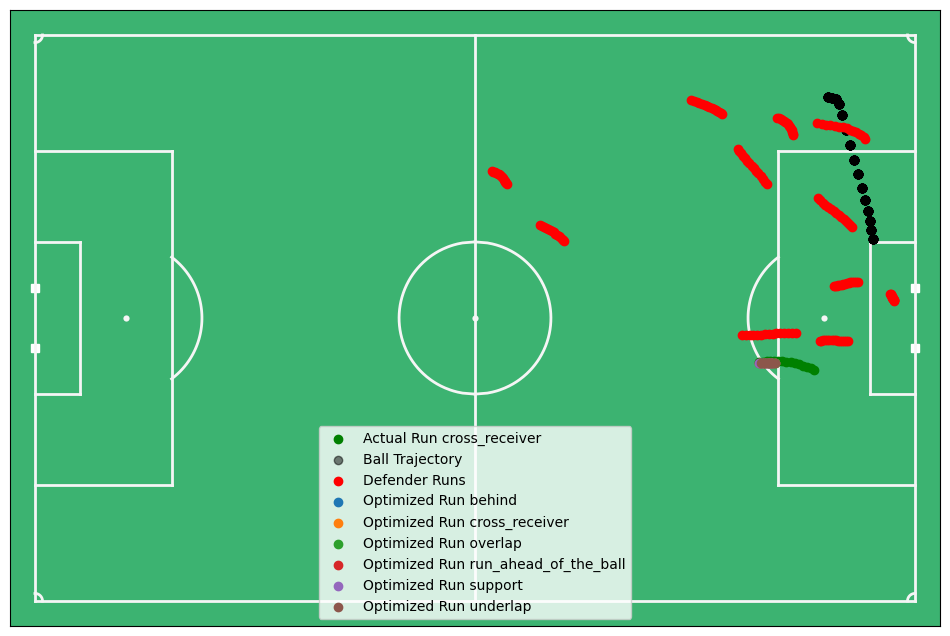

In [42]:
%matplotlib inline
plot_optimal_run2(run,tracking_frame_groups=tracking_frame_groups,player_to_team=player_to_team,run_dict=run_type_dict)

# Animate Optimal Run

In [46]:
type_to_animate = "cross_receiver"

In [47]:
# Transform for animation
run_tracking = tracking_frame_groups[(match_id, run_id)].sort_values('frame_id')
absolute_path = absolute_path = run_type_dict[type_to_animate]["run_path"]
pred_x = pd.Series(absolute_path[:,0])
pred_y = pd.Series(absolute_path[:,1])
dx = pred_x - pred_x.shift(1)
dy = pred_y - pred_y.shift(1)
s = np.sqrt(dx**2 + dy**2) * 10
d = np.arctan2(dy,dx)
pred_vals = pd.concat([pred_x,pred_y,dx,dy,s,d],axis=1)
pred_vals.columns = ["x","y","dx","dy","s","d"]
pred_vals["player"] = -1
pred_run = run_tracking[(run_tracking.run_active) & (run_tracking.player==runner_id)].copy()
pred_run.loc[:,["x","y","dx","dy","s","d","player"]] = pred_vals.fillna(0).values

ValueError: Length of values (5) does not match length of index (15)

In [267]:
%matplotlib tk

run_tracking_with_pred = pd.concat([run_tracking,pred_run])
animate_run(run=run,tracking_data=run_tracking_with_pred,player_to_team=player_to_team)